In [1]:
import os

os.getcwd()
datafile_path = '../data'

In [2]:
import glob
from natsort import natsorted
from pprint import pprint

search_path = '../data/*/*'
path_list = natsorted(glob.glob(search_path))

In [3]:
pprint(path_list)

[]


In [4]:
path_list[0]

IndexError: list index out of range

In [5]:
import mne

raw = mne.io.read_raw_gdf(path_list[0])

Extracting EDF parameters from /home/biolab/upper-limb-movements-decoder-from-eeg/data/S01_ME/motorexecution_subject1_run1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
/home/biolab/upper-limb-movements-decoder-from-eeg/venv/lib/python3.6/site-packages/mne/io/edf/edf.py:1001: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


In [6]:
pprint(raw.ch_names)

['eeg-0',
 'eeg-1',
 'eeg-2',
 'eeg-3',
 'eeg-4',
 'eeg-5',
 'eeg-6',
 'eeg-7',
 'eeg-8',
 'eeg-9',
 'eeg-10',
 'eeg-11',
 'eeg-12',
 'eeg-13',
 'eeg-14',
 'eeg-15',
 'eeg-16',
 'eeg-17',
 'eeg-18',
 'eeg-19',
 'eeg-20',
 'eeg-21',
 'eeg-22',
 'eeg-23',
 'eeg-24',
 'eeg-25',
 'eeg-26',
 'eeg-27',
 'eeg-28',
 'eeg-29',
 'eeg-30',
 'eeg-31',
 'eeg-32',
 'eeg-33',
 'eeg-34',
 'eeg-35',
 'eeg-36',
 'eeg-37',
 'eeg-38',
 'eeg-39',
 'eeg-40',
 'eeg-41',
 'eeg-42',
 'eeg-43',
 'eeg-44',
 'eeg-45',
 'eeg-46',
 'eeg-47',
 'eeg-48',
 'eeg-49',
 'eeg-50',
 'eeg-51',
 'eeg-52',
 'eeg-53',
 'eeg-54',
 'eeg-55',
 'eeg-56',
 'eeg-57',
 'eeg-58',
 'eeg-59',
 'eeg-60',
 'eog-r',
 'eog-m',
 'eog-l',
 'thumb_near',
 'thumb_far',
 'thumb_index',
 'index_near',
 'index_far',
 'index_middle',
 'middle_near',
 'middle_far',
 'middle_ring',
 'ring_near',
 'ring_far',
 'ring_little',
 'litte_near',
 'litte_far',
 'thumb_palm',
 'wrist_bend',
 'roll',
 'pitch',
 'gesture',
 'handPosX',
 'handPosY',
 'handPosZ',

In [7]:
import matplotlib.pyplot as plt
# plt.plot(raw['eeg-0'][0])

In [8]:
type(raw)

mne.io.edf.edf.RawGDF

In [9]:
type(raw['eeg-0'][0])

numpy.ndarray

In [10]:
raw.info.keys()

dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

In [11]:
print(raw.info)

<Info | 7 non-empty values
 bads: []
 ch_names: eeg-0, eeg-1, eeg-2, eeg-3, eeg-4, eeg-5, eeg-6, eeg-7, eeg-8, ...
 chs: 96 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: 2015-05-26 15:42:48 UTC
 nchan: 96
 projs: []
 sfreq: 512.0 Hz
>


In [12]:
tmp = raw['eeg-0'][0].flatten()

In [13]:
raw.info['sfreq']

512.0

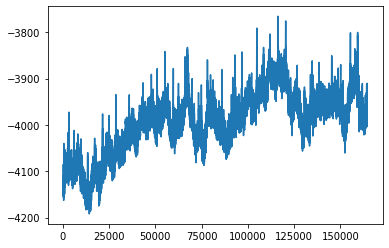

In [14]:
plt.plot(tmp[8:])

# Preprocessing
- remove noizy channels
- Downsampled the data to 256Hz
- mark artifacts 
    1. by band-pass filter(0.3-70Hz, 4th order zero-phase Butterworth filter)
    2. find values above/below thresholds of -200uV and 200uV from data
    3. 


## Downsample
Used scipy.signal.resample()

In [15]:
import numpy as np
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
secs = (raw['eeg-0'][0]).shape[1] // int(raw.info['sfreq'])
samples = secs * 256
tmmp = signal.resample(tmp[~np.isnan(tmp)], samples)

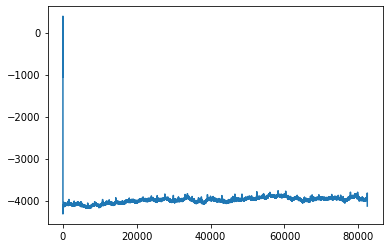

In [16]:
plt.plot(tmmp)

## Butterworth Filter
band-pass filtering (0.3 Hz—70 Hz, 4th order zero-phase Butterworth filter)


In [17]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

In [52]:
b, a = butter_bandpass(0.3, 70, 256, 4)

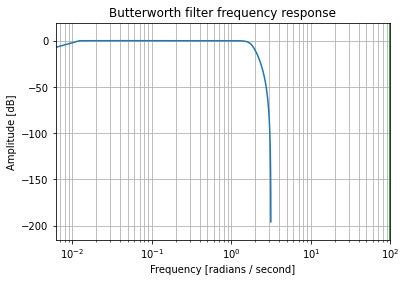

In [54]:
w, h = signal.freqz(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

In [55]:
def plot_fft(sig, fs):
    N = len(sig)
    T = 1.0 / fs
    sig = sig * signal.blackman(N)
    sig_f = fft(sig)
    xf = fftfreq(N, T)
    xf = fftshift(xf)
    yplot = fftshift(sig_f)
    plt.plot(xf, 1.0/N * np.abs(yplot))
    plt.xlim(0, 2)
    plt.grid()
    plt.show()
    

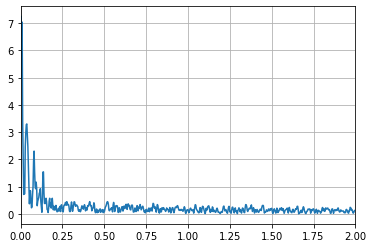

In [56]:
plot_fft(tmmp-np.mean(tmmp), 256)

In [57]:
tmmp.shape

(82432,)

In [61]:
def fft_for_signal(sig, fs):
    sp = fftshift(fft(sig))
    freq = fftshift(fftfreq(sig.shape[-1], 1/fs))
    return sp, freq

def plot_signal_fft(sig, fs):
    focused_signal = sig[8:]
    focused_sp, focused_freq = fft_for_signal(focused_signal, fs)
    
    plt.subplot(2,1,1)
    plt.plot(focused_signal)
    plt.subplot(2,1,2) 
    plt.plot(focused_freq[int(len(focused_signal)//2):-1], 
        np.abs(focused_sp[int(len(focused_signal)//2):-1]))
    plt.xlim([0, 1])
    plt.ylim([0, 70000])
    # plt.autoscale(tight=True)
    plt.show()

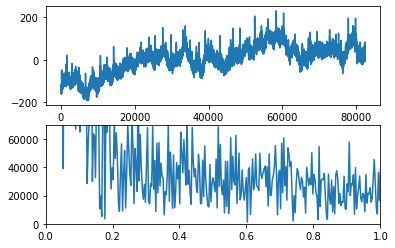

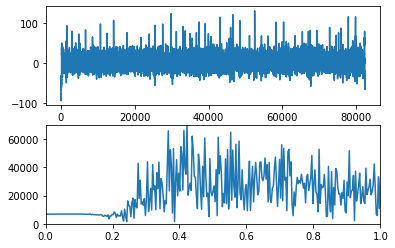

In [64]:
plot_signal_fft(tmmp[8:-8]-np.mean(tmmp[8:-8]), 256)
filtered = signal.filtfilt(b, a, tmmp[8:-8]-np.mean(tmmp[8:-8]))
plot_signal_fft(filtered, 256)

Next, 
Mark artifacts judged by threshold of +_ 200uV.